In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn

import torch.optim as optim

from copy import deepcopy

from torch.distributions import Categorical

import itertools

import sys
sys.path.insert(0, './../libraries/')

import partial_marginalization_lib as pm_lib
import gmm_experiments_lib as gmm_lib

In [2]:
softmax = nn.Softmax(dim = 0)

sigmoid = nn.Sigmoid()

In [3]:
import torch

In [4]:
np.random.seed(45224)
_ = torch.manual_seed(45224)

# Draw data

In [5]:
mu0 = torch.Tensor([0, 0])
sigma0 = 4.
n_clusters = 5

n_obs = 200

In [6]:
gmm_experiment = gmm_lib.GMMExperiments(n_obs, mu0, sigma0, n_clusters, hidden_dim=100)

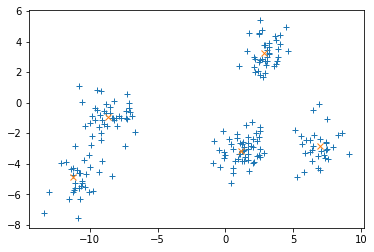

In [7]:
plt.plot(gmm_experiment.y[:, 0].numpy(), gmm_experiment.y[:, 1].numpy(), '+')
plt.plot(gmm_experiment.true_mus[:, 0].numpy(), gmm_experiment.true_mus[:, 1].numpy(), 'x')

# Set up marginalization class and run k-means init

In [8]:
obj_class_reinforce = pm_lib.PartialMarginalizationREINFORCE(gmm_experiment)

In [12]:
obj_class_reinforce.experiment_class.set_kmeans_init_var_params()
# obj_class_reinforce.experiment_class.set_random_var_params()

k_means_init_params = deepcopy(obj_class_reinforce.experiment_class.var_params)

In [13]:
# check kmeans init
centroids_init = obj_class_reinforce.experiment_class.var_params['centroids']
obj_class_reinforce.set_and_get_log_q()

z_ind = np.argmax(obj_class_reinforce.class_weights.numpy(), axis = 1)

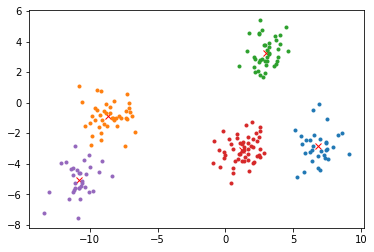

In [14]:
plt.figure()

plt.plot(centroids_init[:, 0].detach().numpy(), 
         centroids_init[:, 1].detach().numpy(), 'x', color = 'red')
# plt.plot(gmm_experiment.true_mus[:, 0].numpy(), 
#          gmm_experiment.true_mus[:, 1].numpy(), 'x', color = 'blue')

for i in range(n_clusters): 
    plt.plot(gmm_experiment.y.numpy()[z_ind == i, 0], 
            gmm_experiment.y.numpy()[z_ind == i, 1], '.')


# Train with true gradient

In [15]:
vb_params_opt, loss_array_true_grad = obj_class_reinforce.run_SGD(alpha=0.0, topk = 1, lr = 1e-2, n_steps=1000, 
                                               use_true_grad = True)

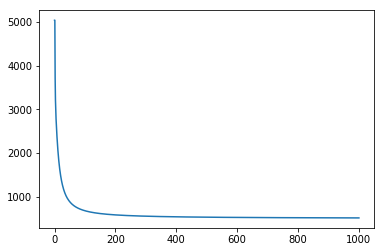

In [16]:
plt.plot(loss_array_true_grad)

In [17]:
print('initial elbo: ', loss_array_true_grad[0])

initial elbo:  5039.4169921875


In [18]:
print('final elbo: ', loss_array_true_grad[-1])

final elbo:  512.8735961914062


In [19]:
obj_class_reinforce.experiment_class.var_params['log_sigma']

tensor([-0.1319])

In [20]:
class_weights_opt = deepcopy(obj_class_reinforce.class_weights)
centroids_opt = vb_params_opt['centroids']
sigma_opt = vb_params_opt['log_sigma']

z_ind = torch.argmax(obj_class_reinforce.class_weights, dim=1).numpy()

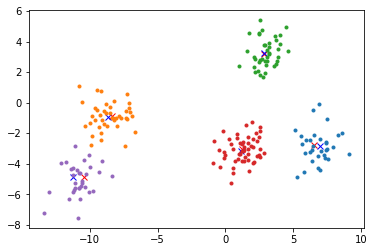

In [21]:
plt.figure()
plt.plot(centroids_opt[:, 0].detach().numpy(), 
         centroids_opt[:, 1].detach().numpy(), 'x', color = 'red')
plt.plot(gmm_experiment.true_mus[:, 0].numpy(), 
         gmm_experiment.true_mus[:, 1].numpy(), 'x', color = 'blue')

for i in range(n_clusters): 
    plt.plot(gmm_experiment.y.numpy()[z_ind == i, 0], 
            gmm_experiment.y.numpy()[z_ind == i, 1], '.')
    

# Is REINFORCE useful at all here?

In [22]:
# Reuse same kmeans init
obj_class_reinforce.experiment_class.var_params['free_class_weights'] = \
    deepcopy(k_means_init_params['free_class_weights'])

obj_class_reinforce.experiment_class.var_params['centroids'] = deepcopy(k_means_init_params['centroids'])
obj_class_reinforce.experiment_class.var_params['log_sigma'] = deepcopy(k_means_init_params['log_sigma'])

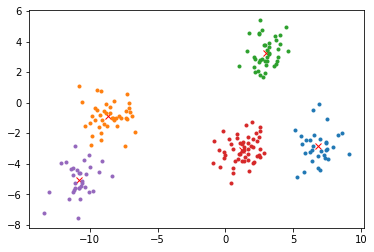

In [23]:
# # check kmeans init
centroids_init = obj_class_reinforce.experiment_class.var_params['centroids']
obj_class_reinforce.set_and_get_log_q()

z_ind = np.argmax(obj_class_reinforce.class_weights.numpy(), axis = 1)

plt.figure()

plt.plot(centroids_init[:, 0].detach().numpy(), 
         centroids_init[:, 1].detach().numpy(), 'x', color = 'red')
# plt.plot(gmm_experiment.true_mus[:, 0].numpy(), 
#          gmm_experiment.true_mus[:, 1].numpy(), 'x', color = 'blue')

for i in range(n_clusters): 
    plt.plot(gmm_experiment.y.numpy()[z_ind == i, 0], 
            gmm_experiment.y.numpy()[z_ind == i, 1], '.')


In [24]:
vb_params_opt, loss_array_reinforce = obj_class_reinforce.run_SGD(alpha=0.0, topk = 0, 
                                                use_baseline = False, 
                                                lr = 1e-4, n_steps=1000, 
                                               use_true_grad = False)

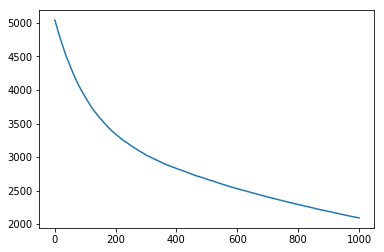

In [25]:
plt.plot(loss_array_reinforce)

In [26]:
print('initial elbo: ', loss_array_reinforce[0])

initial elbo:  5039.4169921875


In [27]:
print('final elbo: ', loss_array_reinforce[-1])

final elbo:  2092.896484375


In [28]:
class_weights_opt = deepcopy(obj_class_reinforce.class_weights)
centroids_opt = vb_params_opt['centroids']
sigma_opt = vb_params_opt['log_sigma']

z_ind = torch.argmax(obj_class_reinforce.class_weights, dim=1).numpy()

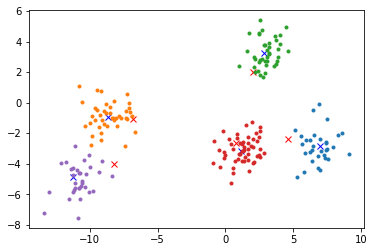

In [29]:
plt.figure()
plt.plot(centroids_opt[:, 0].detach().numpy(), 
         centroids_opt[:, 1].detach().numpy(), 'x', color = 'red')
plt.plot(gmm_experiment.true_mus[:, 0].numpy(), 
         gmm_experiment.true_mus[:, 1].numpy(), 'x', color = 'blue')

for i in range(n_clusters): 
    plt.plot(gmm_experiment.y.numpy()[z_ind == i, 0], 
            gmm_experiment.y.numpy()[z_ind == i, 1], '.')
    

In [30]:
len(loss_array_reinforce)

1001

In [33]:
n_steps = 1000
losses_array_all = np.zeros((n_clusters + 1, n_steps + 1))

for i in range(n_clusters + 1): 
    obj_class_reinforce.experiment_class.var_params['free_class_weights'] = \
    deepcopy(k_means_init_params['free_class_weights'])

    obj_class_reinforce.experiment_class.var_params['centroids'] = deepcopy(k_means_init_params['centroids'])
    obj_class_reinforce.experiment_class.var_params['log_sigma'] = deepcopy(k_means_init_params['log_sigma'])

    print('topk: ', i)
    vb_params_opt, loss_array_reinforce = obj_class_reinforce.run_SGD(alpha=0.0, topk = i, 
                                                    use_baseline = True, 
                                                    lr = 1e-2, n_steps=n_steps, 
                                                   use_true_grad = False)
    
    losses_array_all[i, :] = loss_array_reinforce
    
    print('initial elbo: ', loss_array_reinforce[0])
    print('final elbo: ', loss_array_reinforce[-1])

topk:  0
initial elbo:  5039.4169921875
final elbo:  512.94189453125
topk:  1
initial elbo:  5039.4169921875
final elbo:  512.81494140625
topk:  2
initial elbo:  5039.4169921875
final elbo:  512.8218994140625
topk:  3
initial elbo:  5039.4169921875
final elbo:  512.8743896484375
topk:  4
initial elbo:  5039.4169921875
final elbo:  512.886474609375
topk:  5
initial elbo:  5039.4169921875
final elbo:  512.8865966796875


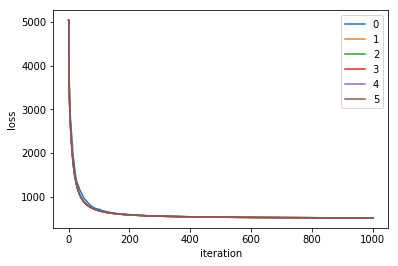

In [34]:
plt.plot(losses_array_all.T, '-')

plt.xlabel('iteration')
plt.ylabel('loss')

plt.legend(('0', '1', '2', '3', '4', '5'))
